<a href="https://colab.research.google.com/github/22842219/ET-DeepSDD/blob/main/Reasoning_process_example__by_Ziyu_Zhao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pysdd
!pip install problog
!pip install PySDD
!pip install graphviz

In [5]:
import pysdd
from pysdd.sdd import Vtree, SddManager, WmcManager
from pathlib import Path
from graphviz import Source
from array import array
from graphviz import Source
import math
from array import array
import random
import torch


In [15]:
def exactly_one(lits, mgr):
  alpha = mgr.false()
  for lit in lits:
    beta = lit
    for lit2 in lits:
      if lit2!=lit:
        beta = beta& ~lit2
    alpha = alpha | beta
  return alpha


In [16]:
def AtMostOne(lits, mgr):
  alpha = mgr.true()
  for lit in lits:
    beta = lit
    for lits in lits:
      if lit2!=lit:
        beta = ~lit2 | beta			
      alpha = alpha | beta
  return alpha

# Problem description
Given a probability distribution learned by any neural network over the output space, and the relationship constraints based on background knowledge, we would like to know how to represent the knowledge and exploit it to affect the neural network. We formulate our problem as a Bayesian inference process.







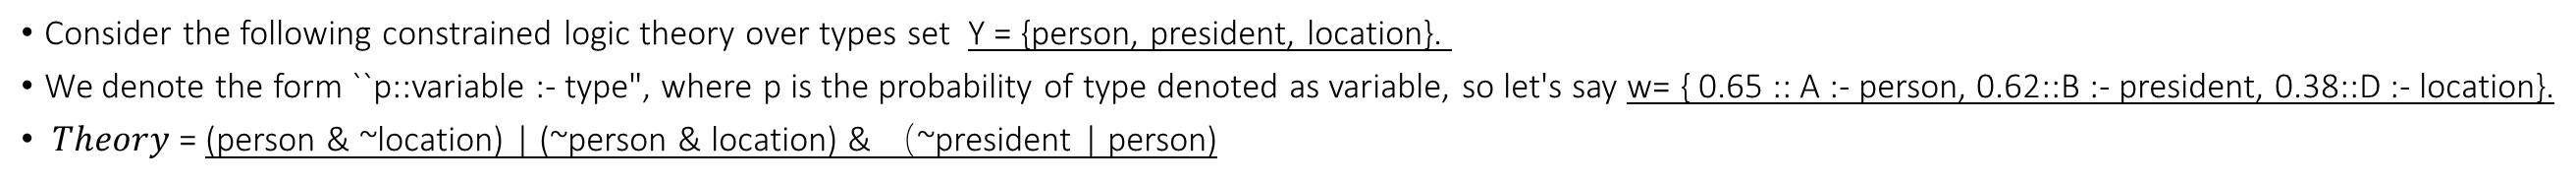

## Vtree


variable count: 3


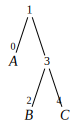

In [17]:
vtree = Vtree(3)
print("variable count: {}".format(vtree.var_count()))
Source(vtree.dot())

## SDD manager

Create new manager with four variables A, B, and C coresponding "person", "president" and "location". The variables can be requested using the literal function or the var property:

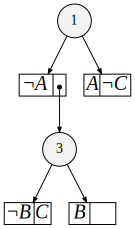

In [18]:
sdd_mgr = SddManager(var_count=3)
person, president, location = sdd_mgr.vars
# create the theory
theory = exactly_one((person, location), sdd_mgr) & (~president | person)
Source(theory.dot())

## WMC manager
Creates a WMC manager for the SDD rooted at node and initializes literal weights.  
Background:  
  Weighted model counting (WMC) is performed with respect to a given SDD and literal weights, and is based on
  the following definitions:
  * The weight of a variable instantiation is the product of weights assigned to its literals.
  * The weighted model count of the SDD is the sum of weights attained by its models. Here, a model is an
    instantiation (of all variables in the manager) that satisfies the SDD.
  * The weighted model count of a literal is the sum of weights attained by its models that are also models of
    the given SDD.
  * The probability of a literal is the ratio of its weighted model count over the one for the given SDD.
  To facilitate the computation of weighted model counts with respect to changing literal weights, a WMC manager
  is created for the given SDD. This manager stores the weights of literals, allowing one to change them, and
  to recompute the corresponding weighted model count each time the weights change.


In [22]:
P = [0.65, 0.62, 0.38]
P = torch.FloatTensor(P)
# Compute mc, wmc
wmc_mgr = theory.wmc(log_mode=False)
mc = wmc_mgr.propagate()
print(f" Model Counting: {mc}")
weights = torch.cat((P, P))
for i , p in enumerate(P):
  weights[i] = 1- P[len(P)-1-i]
weights = array('d',  weights)  

 Model Counting: 3.0


In [23]:
likelihood_pr = []
wmc = []
lits = [None] + [sdd_mgr.literal(i) for i in range(1, sdd_mgr.var_count()+1)]
for i in range(0, sdd_mgr.var_count()):
  wmc_mgr.set_literal_weights_from_array(weights)
  wmc.append( wmc_mgr.propagate())
  print(f"Weighted Model Counting i.e. Pr(theory): {wmc}")
  #condition on literal indexed by i+1 
  wmc_mgr.set_literal_weight(lits[i+1],1)
  wmc_mgr.set_literal_weight(-lits[i+1], 0)
  wmc_pos_con = wmc_mgr.propagate()
  print(f"conditioned wmc on every iterated lit : {wmc_pos_con}")
  likelihood_pr.append(wmc_pos_con )


Weighted Model Counting i.e. Pr(theory): [0.4535399904918669]
conditioned wmc on every iterated lit : 0.6200000047683716
Weighted Model Counting i.e. Pr(theory): [0.4535399904918669, 0.4535399904918669]
conditioned wmc on every iterated lit : 0.4029999883174895
Weighted Model Counting i.e. Pr(theory): [0.4535399904918669, 0.4535399904918669, 0.4535399904918669]
conditioned wmc on every iterated lit : 0.13300000739097584


In [24]:
likelihood_pr = torch.FloatTensor(likelihood_pr)
wmc = torch.FloatTensor(wmc)
# Bayesian rule
joint_pr = torch.mul(likelihood_pr, P)
posterior_pr = torch.div(joint_pr, wmc)
print(f"likelihood probability distribution : {likelihood_pr}")
print(f"Marginal Probability i.e. Pr(theory): {wmc}")
print(f"Joint Probability i.e. Pr(variable, theory): {joint_pr}")
print(f"Posterior probability distribution given theory: {posterior_pr}")

likelihood probability distribution : tensor([0.6200, 0.4030, 0.1330])
Marginal Probability i.e. Pr(theory): tensor([0.4535, 0.4535, 0.4535])
Joint Probability i.e. Pr(variable, theory): tensor([0.4030, 0.2499, 0.0505])
Posterior probability distribution given theory: tensor([0.8886, 0.5509, 0.1114])
